<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [64]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [65]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [66]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [67]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1500000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1500000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]

In [68]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [69]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [70]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [71]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [72]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
723154,3,2,2,25.0,96.081652,0.863916,48.0,11.4,9.6,128750.00000,137833.33330,13,1863857000,25196750000,15718121000,51.659037,-0.034152,423000.0
382980,3,2,2,7.0,96.147761,1.035171,14.0,13.1,13.2,88250.00000,80833.33333,23,11093122000,34446848000,26061863000,51.330293,1.405010,225000.0
827338,3,2,3,15.0,92.924876,0.760058,38.0,9.7,9.1,50000.00000,45625.00000,21,23001131900,5721393000,11248337000,53.443566,-1.389291,83000.0
1112052,5,2,2,6.0,106.060713,1.149207,24.0,9.5,8.9,34375.00000,25666.66667,4,41726022000,19326050000,30011046000,55.172341,-1.564023,79500.0
325788,2,2,3,2.0,95.956379,0.896263,29.0,10.0,7.7,37500.00000,38000.00000,19,24346177000,6475548000,13042187900,53.593926,-1.289886,76000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163275,2,2,2,9.0,38.415672,1.684925,7.0,13.0,13.2,173000.00000,173000.00000,1,2726244900,23323155000,13350374000,51.705124,-0.413702,346000.0
262788,2,2,2,10.0,89.392778,0.897385,47.0,10.6,10.3,42750.00000,43408.33333,18,25452730000,13082154000,17999369000,53.799996,-0.340962,115000.0
52800,2,2,2,20.0,104.120626,1.388097,63.0,8.3,6.0,39875.00000,37500.00000,23,27101351000,6123816000,15029139000,53.811303,-1.507658,75000.0
837379,3,2,4,4.0,39.304475,0.401676,15.0,10.4,9.2,77395.83333,83500.00000,17,17617705000,11396078000,2252304000,52.456291,-2.235312,295000.0


In [73]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '2', ..., 51.659037, -0.034151999999999995, 423000.0],
       [3, '2', '2', ..., 51.330293, 1.40501, 225000.0],
       [3, '2', '3', ..., 53.443566000000004, -1.389291, 83000.0],
       ...,
       [2, '2', '2', ..., 53.811303, -1.507658, 75000.0],
       [3, '2', '4', ..., 52.456291, -2.235312, 295000.0],
       [4, '2', '4', ..., 52.659641, -2.445234, 337500.0]], dtype=object)

In [74]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [75]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [76]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [77]:
from sklearn import preprocessing

In [78]:
min_max_scaler = preprocessing.MinMaxScaler()

In [79]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.33333333, ..., 0.41726789, 0.28850119,
        0.75994369],
       [0.5       , 1.        , 0.33333333, ..., 0.69304977, 0.23183511,
        0.95286258],
       [0.5       , 1.        , 0.66666667, ..., 0.29809579, 0.59610303,
        0.57828804],
       ...,
       [0.25      , 1.        , 0.33333333, ..., 0.39889845, 0.65949038,
        0.562421  ],
       [0.5       , 1.        , 1.        , ..., 0.05824614, 0.42592501,
        0.46487938],
       [0.75      , 1.        , 1.        , ..., 0.10898319, 0.46097674,
        0.43673945]])

In [80]:

print(min(Y1))
print(max(Y1))

14500.0
1499999.0


In [81]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [82]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
1495000.0


In [83]:
from sklearn.model_selection import train_test_split

In [86]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [87]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(724387, 17) (310452, 17) (724387,) (310452,)


In [88]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [89]:
model = Sequential([
    Dense(500, activation='relu', input_shape=X1_train.shape[1:]),
    Dense(1)
])

In [90]:
my_optimizer = keras.optimizers.Adam(learning_rate=0.009)
model.compile(
              loss='mean_squared_error',
               optimizer=my_optimizer)

In [91]:
import numpy as np

In [92]:
X1_train = np.asarray(X1_train).astype('float32')

In [93]:
Y1_train = np.asarray(Y1_train).astype('float32')

In [94]:
X1_test = np.asarray(X1_test).astype('float32')
Y1_test = np.asarray(Y1_test).astype('float32')

In [95]:
hist = model.fit(X1_train, Y1_train,
          epochs=100,
          validation_data=(X1_test, Y1_test))

Epoch 1/100
22638/22638 [==============================] - 41s 2ms/step - loss: 27192533714.2142 - val_loss: 9043125248.0000
Epoch 2/100
22638/22638 [==============================] - 39s 2ms/step - loss: 8503381588.4249 - val_loss: 7452665344.0000
Epoch 3/100
22638/22638 [==============================] - 39s 2ms/step - loss: 7170209459.0044 - val_loss: 6651909120.0000
Epoch 4/100
22638/22638 [==============================] - 39s 2ms/step - loss: 6496830283.6613 - val_loss: 6314104832.0000
Epoch 5/100
22638/22638 [==============================] - 39s 2ms/step - loss: 6214275023.0141 - val_loss: 6186852864.0000
Epoch 6/100
22638/22638 [==============================] - 40s 2ms/step - loss: 6109552672.0353 - val_loss: 6124810752.0000
Epoch 7/100
22638/22638 [==============================] - 39s 2ms/step - loss: 6110238146.0778 - val_loss: 6081896960.0000
Epoch 8/100
22638/22638 [==============================] - 39s 2ms/step - loss: 5977474611.6093 - val_loss: 6045035520.0000
Epoch 9

In [96]:
prediction1=model.predict(X1_test)
#print(prediction1)

In [97]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,14.0,22.716614,0.977673,16.000000,10.000000,8.400000,158166.656250,158166.656250,3.000000,2.131983e+09,2.770049e+10,1.734802e+10,51.323475,-0.209555,240000.0,203779.828125,36220.171875,1.311901e+09,36220.171176,21319830_277004943_173480202
1,3.0,1.0,2.0,10.0,68.892204,0.288515,24.000000,10.999999,8.700000,45000.000000,51666.667969,5.000000,2.825094e+10,3.113373e+09,1.282937e+10,53.526543,-2.715774,124200.0,114120.726562,10079.273438,1.015918e+08,10079.273387,282509414_31133732_128293745
2,2.0,2.0,2.0,5.0,120.625000,0.833127,41.000000,7.900000,7.100000,57249.996094,57333.332031,24.000000,2.207635e+10,9.129903e+09,6.221068e+09,52.714756,-2.742053,116000.0,108340.593750,7659.406250,5.866650e+07,7659.406243,220763525_91299031_62210683
3,4.0,2.0,4.0,15.0,42.940426,2.178858,15.000001,10.599999,11.200000,114250.000000,148541.656250,8.000000,1.491842e+10,3.069811e+10,1.948326e+10,50.728729,-1.901577,390000.0,540349.312500,-150349.312500,2.260492e+10,150349.315715,149184174_306981110_194832589
4,3.0,2.0,3.0,4.0,34.710167,2.579510,12.000000,9.400001,9.200001,69000.000000,71666.664062,8.000000,1.346284e+10,1.257036e+10,4.852551e+09,52.545658,-1.196133,225000.0,206899.359375,18100.640625,3.276332e+08,18100.640431,134628383_125703578_48525507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310447,3.0,2.0,3.0,28.0,66.223656,2.047360,15.000001,12.100000,11.099999,143833.343750,137500.000000,19.000000,1.833649e+09,2.767154e+10,1.783523e+10,51.429028,0.059782,385000.0,453913.375000,-68913.375000,4.749053e+09,68913.376350,18336489_276715377_178352333
310448,5.0,2.0,4.0,5.0,98.021423,2.318756,25.000000,7.900000,7.100000,93500.000000,102500.000000,18.000000,1.170374e+10,1.479156e+10,7.787721e+09,52.501785,-0.755528,602500.0,500646.125000,101853.875000,1.037421e+10,101853.873682,117037363_147915633_77877212
310449,3.0,2.0,3.0,2.0,36.167038,2.827024,19.000000,8.200000,6.800000,82500.000000,88750.000000,14.000001,2.048023e+10,2.625309e+10,1.658415e+10,51.173141,-3.065668,195000.0,240524.171875,-45524.171875,2.072450e+09,45524.171338,204802294_262530867_165841490
310450,2.0,1.0,2.0,7.0,50.872566,1.108546,18.000000,10.699999,9.900001,96000.000000,104333.335938,18.000000,6.837580e+09,1.919255e+10,9.625028e+09,52.035480,-0.692707,72000.0,188222.468750,-116222.468750,1.350766e+10,116222.466950,68375798_191925514_96250276


In [98]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,14.0,22.716614,0.977673,16.000000,10.000000,8.400000,158166.656250,158166.656250,3.000000,2.131983e+09,2.770049e+10,1.734802e+10,51.323475,-0.209555,240000.0,203779.828125,36220.171875,1.311901e+09,36220.171176,21319830_277004943_173480202,NaN,NaN,NaN
1,3.0,1.0,2.0,10.0,68.892204,0.288515,24.000000,10.999999,8.700000,45000.000000,51666.667969,5.000000,2.825094e+10,3.113373e+09,1.282937e+10,53.526543,-2.715774,124200.0,114120.726562,10079.273438,1.015918e+08,10079.273387,282509414_31133732_128293745,NaN,NaN,NaN
2,2.0,2.0,2.0,5.0,120.625000,0.833127,41.000000,7.900000,7.100000,57249.996094,57333.332031,24.000000,2.207635e+10,9.129903e+09,6.221068e+09,52.714756,-2.742053,116000.0,108340.593750,7659.406250,5.866650e+07,7659.406243,220763525_91299031_62210683,NaN,NaN,NaN
3,4.0,2.0,4.0,15.0,42.940426,2.178858,15.000001,10.599999,11.200000,114250.000000,148541.656250,8.000000,1.491842e+10,3.069811e+10,1.948326e+10,50.728729,-1.901577,390000.0,540349.312500,-150349.312500,2.260492e+10,150349.315715,149184174_306981110_194832589,NaN,NaN,NaN
4,3.0,2.0,3.0,4.0,34.710167,2.579510,12.000000,9.400001,9.200001,69000.000000,71666.664062,8.000000,1.346284e+10,1.257036e+10,4.852551e+09,52.545658,-1.196133,225000.0,206899.359375,18100.640625,3.276332e+08,18100.640431,134628383_125703578_48525507,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310447,3.0,2.0,3.0,28.0,66.223656,2.047360,15.000001,12.100000,11.099999,143833.343750,137500.000000,19.000000,1.833649e+09,2.767154e+10,1.783523e+10,51.429028,0.059782,385000.0,453913.375000,-68913.375000,4.749053e+09,68913.376350,18336489_276715377_178352333,NaN,NaN,NaN
310448,5.0,2.0,4.0,5.0,98.021423,2.318756,25.000000,7.900000,7.100000,93500.000000,102500.000000,18.000000,1.170374e+10,1.479156e+10,7.787721e+09,52.501785,-0.755528,602500.0,500646.125000,101853.875000,1.037421e+10,101853.873682,117037363_147915633_77877212,NaN,NaN,NaN
310449,3.0,2.0,3.0,2.0,36.167038,2.827024,19.000000,8.200000,6.800000,82500.000000,88750.000000,14.000001,2.048023e+10,2.625309e+10,1.658415e+10,51.173141,-3.065668,195000.0,240524.171875,-45524.171875,2.072450e+09,45524.171338,204802294_262530867_165841490,NaN,NaN,NaN
310450,2.0,1.0,2.0,7.0,50.872566,1.108546,18.000000,10.699999,9.900001,96000.000000,104333.335938,18.000000,6.837580e+09,1.919255e+10,9.625028e+09,52.035480,-0.692707,72000.0,188222.468750,-116222.468750,1.350766e+10,116222.466950,68375798_191925514_96250276,NaN,NaN,NaN


In [99]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,14.0,22.716614,0.977673,16.000000,10.000000,8.400000,158166.656250,158166.656250,3.000000,2.131983e+09,2.770049e+10,1.734802e+10,51.323475,-0.209555,240000.0,203779.828125,36220.171875,1.311901e+09,36220.171176,21319830_277004943_173480202,NaN,NaN,NaN
1,3.0,1.0,2.0,10.0,68.892204,0.288515,24.000000,10.999999,8.700000,45000.000000,51666.667969,5.000000,2.825094e+10,3.113373e+09,1.282937e+10,53.526543,-2.715774,124200.0,114120.726562,10079.273438,1.015918e+08,10079.273387,282509414_31133732_128293745,NaN,NaN,NaN
2,2.0,2.0,2.0,5.0,120.625000,0.833127,41.000000,7.900000,7.100000,57249.996094,57333.332031,24.000000,2.207635e+10,9.129903e+09,6.221068e+09,52.714756,-2.742053,116000.0,108340.593750,7659.406250,5.866650e+07,7659.406243,220763525_91299031_62210683,NaN,NaN,NaN
3,4.0,2.0,4.0,15.0,42.940426,2.178858,15.000001,10.599999,11.200000,114250.000000,148541.656250,8.000000,1.491842e+10,3.069811e+10,1.948326e+10,50.728729,-1.901577,390000.0,540349.312500,-150349.312500,2.260492e+10,150349.315715,149184174_306981110_194832589,NaN,NaN,NaN
4,3.0,2.0,3.0,4.0,34.710167,2.579510,12.000000,9.400001,9.200001,69000.000000,71666.664062,8.000000,1.346284e+10,1.257036e+10,4.852551e+09,52.545658,-1.196133,225000.0,206899.359375,18100.640625,3.276332e+08,18100.640431,134628383_125703578_48525507,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310447,3.0,2.0,3.0,28.0,66.223656,2.047360,15.000001,12.100000,11.099999,143833.343750,137500.000000,19.000000,1.833649e+09,2.767154e+10,1.783523e+10,51.429028,0.059782,385000.0,453913.375000,-68913.375000,4.749053e+09,68913.376350,18336489_276715377_178352333,NaN,NaN,NaN
310448,5.0,2.0,4.0,5.0,98.021423,2.318756,25.000000,7.900000,7.100000,93500.000000,102500.000000,18.000000,1.170374e+10,1.479156e+10,7.787721e+09,52.501785,-0.755528,602500.0,500646.125000,101853.875000,1.037421e+10,101853.873682,117037363_147915633_77877212,NaN,NaN,NaN
310449,3.0,2.0,3.0,2.0,36.167038,2.827024,19.000000,8.200000,6.800000,82500.000000,88750.000000,14.000001,2.048023e+10,2.625309e+10,1.658415e+10,51.173141,-3.065668,195000.0,240524.171875,-45524.171875,2.072450e+09,45524.171338,204802294_262530867_165841490,NaN,NaN,NaN
310450,2.0,1.0,2.0,7.0,50.872566,1.108546,18.000000,10.699999,9.900001,96000.000000,104333.335938,18.000000,6.837580e+09,1.919255e+10,9.625028e+09,52.035480,-0.692707,72000.0,188222.468750,-116222.468750,1.350766e+10,116222.466950,68375798_191925514_96250276,NaN,NaN,NaN


In [39]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

73697.86537226701

In [101]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.206073724762604 %
Predictions where error is 15% or less :52.48573048329533 %
Predictions where error is 20% or less :64.85157125739245 %
Predictions where error is 50% or more :5.84567018411864 %


In [102]:
prediction_validation=model.predict(X_Validation_scale)

In [103]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,425979.625000,111980,1.25394e+10,111980,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,244163.671875,19163.7,3.67246e+08,19163.7,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,112101.328125,-7898.67,6.2389e+07,7898.67,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,400549.343750,-99450.7,9.89043e+09,99450.7,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,47738.691406,-4261.31,1.81588e+07,4261.31,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,421323.750000,104324,1.08834e+10,104324,148740500_304966640_192878440
35056,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,420685.843750,26935.8,7.2554e+08,26935.8,228863930_47702200_72125650
35057,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,600221.125000,40221.1,1.61774e+09,40221.1,69380650_274338630_194833210
35058,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,591122.937500,49122.9,2.41306e+09,49122.9,75486840_327653040_219925370


In [104]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,425979.625000,111980,1.25394e+10,111980,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,244163.671875,19163.7,3.67246e+08,19163.7,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,112101.328125,-7898.67,6.2389e+07,7898.67,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,400549.343750,-99450.7,9.89043e+09,99450.7,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,47738.691406,-4261.31,1.81588e+07,4261.31,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,421323.750000,104324,1.08834e+10,104324,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
35056,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,420685.843750,26935.8,7.2554e+08,26935.8,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
35057,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,600221.125000,40221.1,1.61774e+09,40221.1,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
35058,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,591122.937500,49122.9,2.41306e+09,49122.9,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [105]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [106]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

72231.75183628785

In [107]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :36.94523673702225 %
Predictions where error is 15% or less :51.988020536223615 %
Predictions where error is 20% or less :63.97604107244723 %
Predictions where error is 50% or more :5.978322875071306 %


In [108]:
import matplotlib.pyplot as plt

In [109]:
import numpy as np

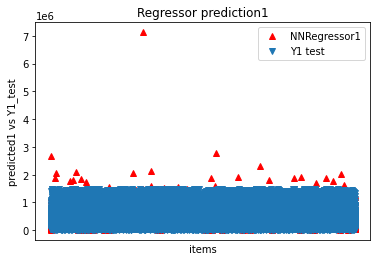

In [110]:
plt.figure()
plt.plot(prediction1, 'r^', label='NNRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

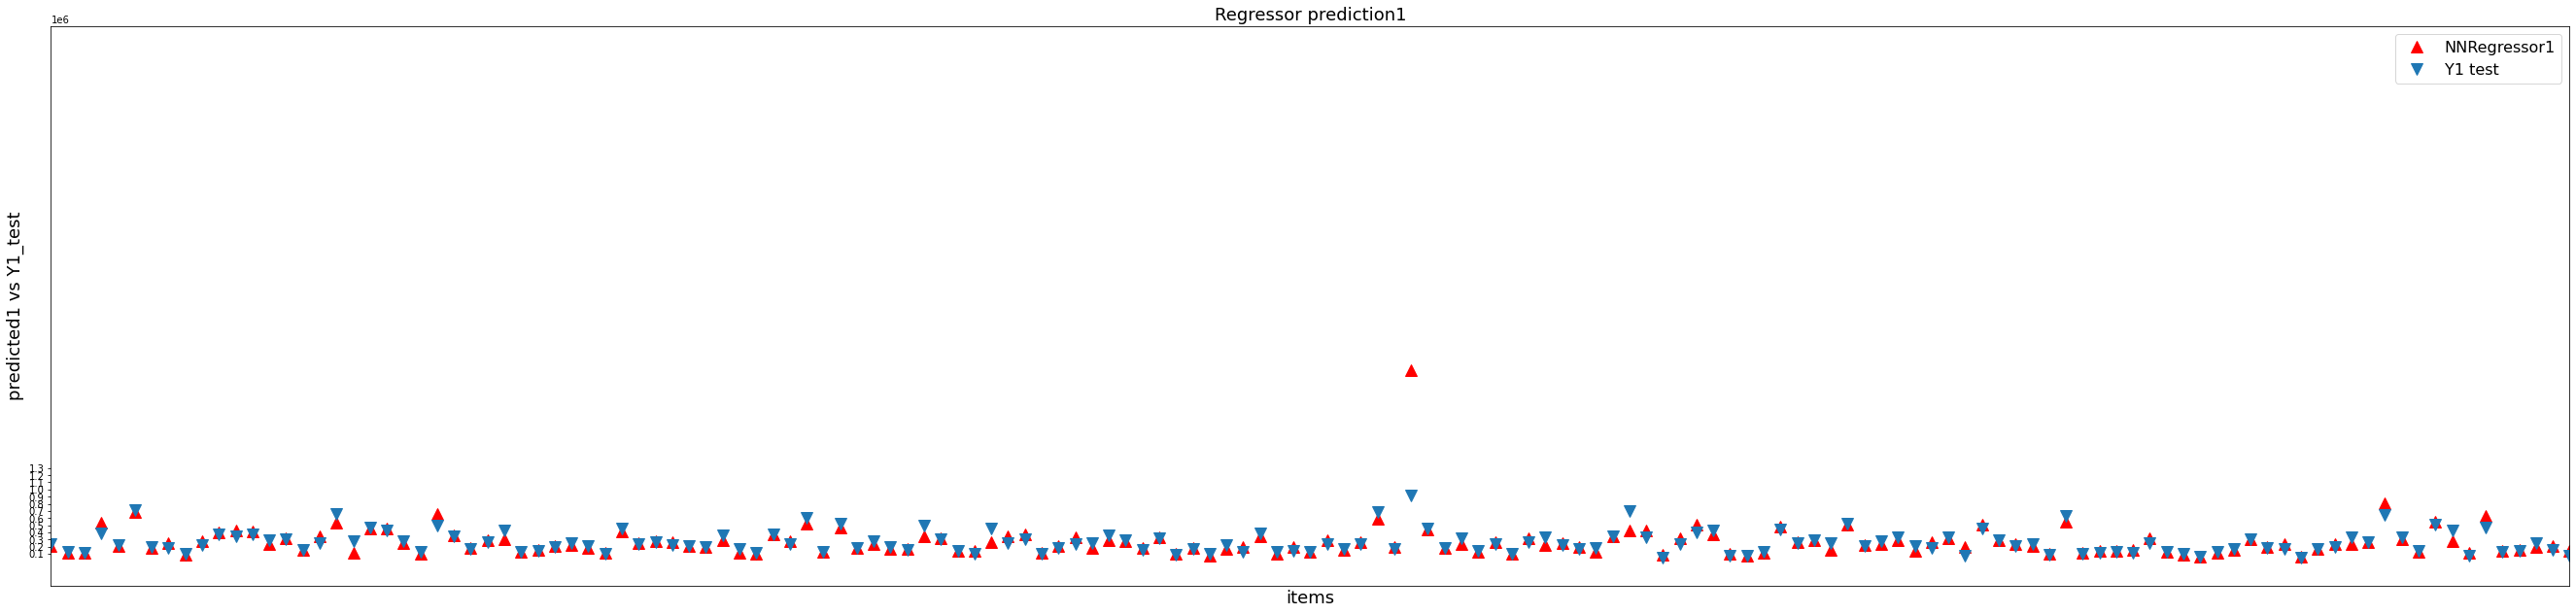

In [111]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='NNRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [112]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [113]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

73697.86536935788

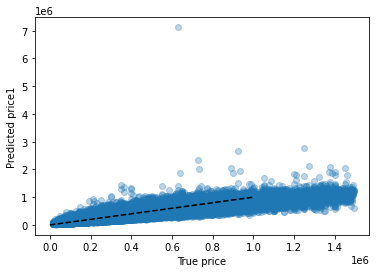

In [114]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [115]:
#test data has several very bad predictions:
#test prediction_90pc_df1
prediction_over90pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=90) ] 
within_90pc_error1=100*prediction_over90pc_df1.shape[0]/prediction_df1.shape[0]
print('Test predictions where error is 90% or more :' + str(within_90pc_error1) + ' %')

Test predictions where error is 90% or more :1.42985066934663 %


In [116]:
prediction_over90pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
81,3.0,2.0,2.0,60.0,84.803658,0.565012,37.000000,10.300000,9.700000,699375.000000,1.456250e+06,10.000000,2.531330e+08,2.627893e+10,1.626739e+10,51.492279,-0.154072,922500.0,2.674503e+06,-1.752003e+06,3.069515e+12,1.752003e+06,2531330_262789284_162673859,189.919028
96,3.0,2.0,2.0,10.0,59.080631,2.359292,42.000000,8.600000,8.300000,35000.000000,3.166667e+04,8.000000,3.620571e+10,1.355385e+10,2.414424e+10,54.646664,-1.643257,40000.0,8.096012e+04,-4.096012e+04,1.677731e+09,4.096012e+04,362057073_135538514_241442406,102.400293
114,2.0,1.0,2.0,6.0,75.640656,0.429867,23.000000,9.900000,8.300000,118416.664062,9.833333e+04,14.000001,6.695203e+09,1.933512e+10,9.707685e+09,52.019573,-0.694570,69000.0,1.951507e+05,-1.261507e+05,1.591399e+10,1.261507e+05,66952028_193351250_97076849,182.827062
150,3.0,2.0,3.0,10.0,101.631813,0.369203,27.000002,10.000000,9.100000,46499.996094,4.500000e+04,15.000000,2.709848e+10,1.928773e+09,1.296404e+10,53.638931,-2.130049,71000.0,1.405510e+05,-6.955098e+04,4.837340e+09,6.955099e+04,270984847_19287731_129640397,97.959135
170,1.0,1.0,1.0,60.0,101.558502,0.923061,44.000000,10.599999,9.500000,750000.000000,1.165000e+06,20.000000,1.768540e+08,2.585620e+10,1.587951e+10,51.528191,-0.176984,362500.0,1.194577e+06,-8.320766e+05,6.923515e+11,8.320766e+05,1768540_258562007_158795110,229.538383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310114,3.0,1.0,3.0,18.0,81.521111,0.446240,13.000000,10.800000,11.099999,37000.000000,3.700000e+04,2.000000,2.616863e+10,1.224670e+09,1.196461e+10,53.550056,-2.106789,75000.0,1.498130e+05,-7.481295e+04,5.596978e+09,7.481295e+04,261686313_12246700_119646147,99.750606
310332,2.0,1.0,1.0,14.0,62.959717,0.688453,10.000000,14.000000,12.500000,102916.664062,1.000000e+05,5.000000,3.693042e+09,2.873197e+10,1.931240e+10,51.441238,0.352809,86000.0,2.220980e+05,-1.360980e+05,1.852267e+10,1.360980e+05,36930417_287319695_193124024,158.253521
310335,3.0,2.0,2.0,39.0,84.712875,1.550876,39.000000,10.099999,9.500000,140625.000000,1.346667e+05,6.000000,1.797972e+09,2.688005e+10,1.728662e+10,51.528584,0.091031,170000.0,3.866906e+05,-2.166906e+05,4.695483e+10,2.166906e+05,17979720_268800492_172866150,127.465075
310352,3.0,2.0,2.0,8.0,83.969856,0.940254,28.000000,7.700000,7.800000,39500.000000,3.800000e+04,7.000000,2.919500e+10,3.881071e+09,1.512878e+10,53.829243,-2.208747,46000.0,9.504016e+04,-4.904016e+04,2.404937e+09,4.904016e+04,291950019_38810708_151287788,106.609036


In [117]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

72231.75183628853

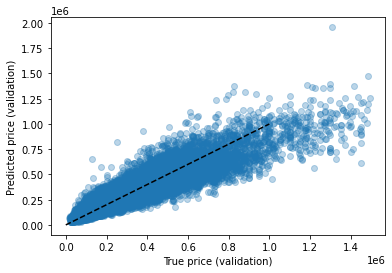

In [118]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()

In [119]:
#validation data has several very bad predictions:
#validation prediction_90pc_df1
prediction_over90pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=90) ] 
within_90pc_error1_val=100*prediction_over90pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 90% or more :' + str(within_90pc_error1_val) + ' %')

Predictions where error is 90% or more :1.414717626925271 %


In [120]:
prediction_over90pc_df1_val

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,error_perc
17,1.0,1.0,1.0,18.0,88.726289,0.888273,12.0,11.8,11.2,90208.33333,75187.50000,26.0,3.982967e+10,1.783974e+10,2.833047e+10,55.013802,-1.439469,49500,103795.898438,54295.9,2.94804e+09,54295.9,398296690_178397430_283304660,109.689
160,1.0,1.0,1.0,6.0,75.156867,0.453190,23.0,9.9,8.3,122000.00000,108750.00000,26.0,6.681220e+09,1.934935e+10,9.718739e+09,52.018293,-0.693980,58500,131742.375000,73242.4,5.36445e+09,73242.4,66812200_193493480_97187390,125.201
198,1.0,1.0,2.0,5.0,82.711422,0.523760,24.0,9.8,8.8,36350.00000,38916.66667,26.0,4.112260e+10,1.886020e+10,2.948362e+10,55.122615,-1.519202,31000,59830.750000,28830.8,8.31212e+08,28830.8,411226050_188601990_294836150,93.0024
215,1.0,1.0,1.0,41.0,87.548348,1.004739,50.0,0.4,0.4,225625.00000,240281.25000,26.0,6.058120e+08,2.573092e+10,1.561322e+10,51.511629,-0.255135,140000,292693.593750,152694,2.33153e+10,152694,6058120_257309160_156132240,109.067
245,1.0,1.0,1.0,16.0,90.695811,0.811408,54.0,9.0,5.7,50000.00000,50500.00000,26.0,3.449683e+10,1.330220e+10,2.323720e+10,54.539786,-1.303136,32000,70934.585938,38934.6,1.5159e+09,38934.6,344968260_133022010_232371960,121.671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34954,5.0,2.0,4.0,23.0,106.495958,0.424742,72.0,8.2,7.6,57000.00000,56666.66667,26.0,2.850524e+10,5.328915e+09,1.262060e+10,53.386753,-3.039939,162000,354128.156250,192128,3.69132e+10,192128,285052449_53289150_126205970,118.598
35008,5.0,2.0,2.0,14.0,98.318898,1.489947,60.0,11.8,9.5,41666.66667,39000.00000,26.0,3.473978e+10,1.344772e+10,2.343772e+10,54.559854,-1.320500,89000,179441.500000,90441.5,8.17966e+09,90441.5,347397750_134477230_234377160,101.62
35027,5.0,1.0,2.0,10.0,56.960515,1.130315,33.0,8.4,6.8,50500.00000,58325.00000,26.0,2.939118e+10,3.483122e+09,1.483113e+10,53.779837,-2.410257,113500,225664.812500,112165,1.25809e+10,112165,293911850_34831220_148311340,98.8236
35040,5.0,2.0,4.0,9.0,63.496471,2.380537,21.0,10.1,9.0,49125.00000,55000.00000,26.0,3.268831e+10,6.852067e+09,1.732730e+10,53.883061,-3.039913,160000,355152.500000,195152,3.80845e+10,195152,326883130_68520670_173273010,121.97
